In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
sys.path.append("../../src/")
sys.path.append("../../src/model")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import wandb # This is optinal 
wandb.login(host = "https://api.wandb.ai") 


/home/ueharam1/miniconda3/envs/GRELU1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ma61sa136 (fderc_diffusion). Use `wandb login --relogin` to force relogin


True

# Load pre-trained model 

In [6]:
run = wandb.init(entity ='fderc_diffusion', project="Diffusion-DNA-RNA", name = "test") # Change depending on your proejcts
artifact = run.use_artifact('DNA-model:v0')
dir = artifact.download()
wandb.finish()


class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    time_schedule = "artifacts/DNA-dataset:v0/time_dependent.npz"
    checkpoint_path = 'artifacts/DNA-model:v0/diffusion_unconditional_epoch=054.ckpt'
config = ModelParameters() 
DEVICE = "cuda:4" # Any number is fine


reward,▁▂▃▃█▇▇▇▇▇▇▇▇
reward,1.36754


wandb: Downloading large artifact DNA-model:v0, 1318.41MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.9


In [13]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [14]:
# Load Reward model
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/DNA-model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)[:,0]


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [15]:
from src.model import ddsm_PPO  as fine_tune

import os
save_name = "./log_finetune2/"
isExist = os.path.exists(save_name)
if not isExist:
   os.makedirs(save_name)

loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate = 5e-3, num_epoch = 1000, length = 50, num_steps = 50, accmu = 6, \
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


reward,▁▃█▂▃
reward,0.45311


100%|██████████| 50/50 [00:01<00:00, 38.71it/s]


0.10514353960752487


100%|██████████| 50/50 [00:01<00:00, 38.13it/s]


0.5057414770126343


100%|██████████| 50/50 [00:01<00:00, 37.71it/s]


0.5965479016304016


100%|██████████| 50/50 [00:01<00:00, 38.89it/s]


0.7330675721168518


100%|██████████| 50/50 [00:01<00:00, 35.06it/s]


1.065079689025879


100%|██████████| 50/50 [00:01<00:00, 31.96it/s]


1.1810393333435059


100%|██████████| 50/50 [00:01<00:00, 31.71it/s]


0.5192078948020935


100%|██████████| 50/50 [00:01<00:00, 33.67it/s]


0.4564943313598633


100%|██████████| 50/50 [00:01<00:00, 37.82it/s]


0.4570208191871643


100%|██████████| 50/50 [00:01<00:00, 37.31it/s]


0.4569566249847412


100%|██████████| 50/50 [00:01<00:00, 38.23it/s]


0.45688197016716003


100%|██████████| 50/50 [00:01<00:00, 35.99it/s]


0.45664727687835693


100%|██████████| 50/50 [00:01<00:00, 31.65it/s]


0.4568682312965393


100%|██████████| 50/50 [00:01<00:00, 32.13it/s]


0.4569222331047058


100%|██████████| 50/50 [00:01<00:00, 37.77it/s]


0.4569137692451477


100%|██████████| 50/50 [00:01<00:00, 38.87it/s]


0.45678186416625977


100%|██████████| 50/50 [00:01<00:00, 39.15it/s]


0.45685824751853943


100%|██████████| 50/50 [00:01<00:00, 38.64it/s]


0.45703327655792236


100%|██████████| 50/50 [00:01<00:00, 35.24it/s]


0.4592706859111786


100%|██████████| 50/50 [00:01<00:00, 31.85it/s]


0.4578469395637512


100%|██████████| 50/50 [00:01<00:00, 31.72it/s]


0.4573180675506592


100%|██████████| 50/50 [00:01<00:00, 36.21it/s]


0.45706307888031006


100%|██████████| 50/50 [00:01<00:00, 38.25it/s]


0.45251744985580444


100%|██████████| 50/50 [00:01<00:00, 37.41it/s]


1.370270013809204


100%|██████████| 50/50 [00:01<00:00, 38.14it/s]


1.3154751062393188


100%|██████████| 50/50 [00:01<00:00, 37.54it/s]


1.3168350458145142


100%|██████████| 50/50 [00:01<00:00, 31.74it/s]


1.4644625186920166


100%|██████████| 50/50 [00:01<00:00, 31.77it/s]


1.3892570734024048


100%|██████████| 50/50 [00:01<00:00, 33.97it/s]


1.369764804840088


100%|██████████| 50/50 [00:01<00:00, 38.45it/s]


1.367035984992981


100%|██████████| 50/50 [00:01<00:00, 37.52it/s]


1.3666608333587646


100%|██████████| 50/50 [00:01<00:00, 39.21it/s]


1.3667736053466797


100%|██████████| 50/50 [00:01<00:00, 35.26it/s]


1.3666088581085205


100%|██████████| 50/50 [00:01<00:00, 31.98it/s]


1.3670520782470703


100%|██████████| 50/50 [00:01<00:00, 31.94it/s]


1.3668886423110962


100%|██████████| 50/50 [00:01<00:00, 36.51it/s]


1.3671308755874634


100%|██████████| 50/50 [00:01<00:00, 37.17it/s]


1.3616631031036377


100%|██████████| 50/50 [00:01<00:00, 37.99it/s]


0.930251955986023


100%|██████████| 50/50 [00:01<00:00, 35.31it/s]


0.4564344882965088


100%|██████████| 50/50 [00:01<00:00, 31.77it/s]


0.455857515335083


100%|██████████| 50/50 [00:01<00:00, 31.28it/s]


0.455824077129364


100%|██████████| 50/50 [00:01<00:00, 36.95it/s]


0.45586103200912476


100%|██████████| 50/50 [00:00<00:00, 65.54it/s]


0.4559482932090759


100%|██████████| 50/50 [00:00<00:00, 65.68it/s]


0.4559926390647888


 18%|█▊        | 9/50 [00:00<00:00, 113.80it/s]


KeyboardInterrupt: 

# Evaluation 

In [31]:
#### Load Fine-Tuned Model 
time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("./log_finetune2/_173.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 



ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [32]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:00<00:00, 124.30it/s]


In [33]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [27]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

100%|██████████| 100/100 [00:00<00:00, 132.96it/s]


In [28]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

In [29]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

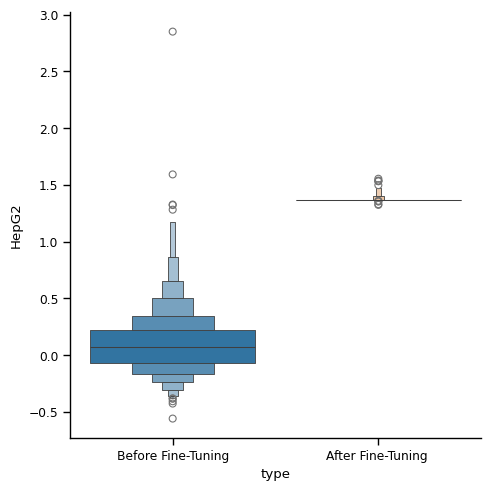

In [34]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")



